<a href="https://colab.research.google.com/github/jrakhshanda/Bayesian-Methods/blob/master/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pyLDAvis
#!pip uninstall scispacy -y
!pip uninstall spacy 
!pip install -U spacy==2.3.0 
!pip install  scispacy==v0.2.5
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_core_sci_md-0.2.5.tar.gz

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import wordnet

import regex as re
from nltk.stem.porter import PorterStemmer 
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import pickle
import os
from os.path import isfile, join
import string

#for vectorizing
nltk.download('stopwords')
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

import gensim

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint

import spacy
import scispacy
import en_core_sci_md

import pyLDAvis.gensim
import pickle 
import pyLDAvis


from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols.extend(['lightcoral','violet'])

#comment this out if you're not able to view any of the print lines
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Data

In [230]:
df = pd.read_csv('/content/drive/MyDrive/data/data.zip', compression='zip', header=0)
df = df.loc[:,~df.columns.str.match("Unnamed")]
df.head()

PMID  ...                                                                                             Abstract
0  33581499  ...  The maintenance of telomeres, which are specialized stretches of DNA found at the ends of linear...
1  33581339  ...  COVID-19 and its causative pathogen SARS-CoV-2 have rushed the world into a staggering pandemic ...
2  33580188  ...  H2A.B is an evolutionarily distant histone H2A variant that accumulates on DNA repair sites, DNA...
3  33580181  ...  Gliosarcoma is a variant of glioblastoma with equally poor prognosis and characterized by mixed ...
4  33580144  ...  Arsenic is reportedly a biphasic inorganic compound for its toxicity and anticancer effects in h...

[5 rows x 3 columns]

In [231]:
df['Title'] = df['Title'].astype('string')
df['Abstract'] = df['Abstract'].astype('string')
df['Text'] = df['Title'] + '. ' + df['Abstract']
df.Text = df.Text.astype('string')

In [232]:
df.dtypes

PMID         int64
Title       string
Abstract    string
Text        string
dtype: object

# Reuseable Routiens

In [3]:
def save_object(path, filename, obj):
    print('Saving Object')
    path_file = join(path, filename)    
    pickle.dump(obj, open(path_file, 'wb'))
    print('Save complete')

def load_object(path, filename):
    print('Attempting to Load Object')
    path_file = join(path, filename)    
    obj = pickle.load(open(path_file, "rb" ))
    print('Load complete')
    return obj

def save_csv(path, filename, dataframe):
    print('Saving Dataframe to CSV')
    path_file = join(path, filename)    
    dataframe.to_csv(path_file, index=False)

def load_csv(path, filename):
    print('Loading Dataframe From CSV')
    path_file = join(path, filename)
    dataframe = pd.read_csv(path_file)
    return dataframe

# Pre-processing
**Tokenization and Cleaning**

In [7]:
def cleaned_tokens(df): 
  
  tokenizer = RegexpTokenizer(r'\w+')
  for row in df['Text']:
    row = ' '.join(filter(lambda word:word.replace('.','').isdigit()==False, row.split()))
    row = re.sub("\'", "", row)  # remove single quotes
    words_tokens = tokenizer.tokenize(row)  
    yield words_tokens  


In [8]:
data_words = list(cleaned_tokens(df))
print(data_words[:1])

[['PCNA', 'a', 'focus', 'on', 'replication', 'stress', 'and', 'the', 'alternative', 'lengthening', 'of', 'telomeres', 'pathway', 'The', 'maintenance', 'of', 'telomeres', 'which', 'are', 'specialized', 'stretches', 'of', 'DNA', 'found', 'at', 'the', 'ends', 'of', 'linear', 'chromosomes', 'is', 'a', 'crucial', 'step', 'for', 'the', 'immortalization', 'of', 'cancer', 'cells', 'Approximately', '10', '15', 'of', 'cancer', 'cells', 'use', 'a', 'homologous', 'recombination', 'based', 'mechanism', 'known', 'as', 'the', 'Alternative', 'Lengthening', 'of', 'Telomeres', 'ALT', 'pathway', 'to', 'maintain', 'their', 'telomeres', 'Telomeres', 'in', 'general', 'pose', 'a', 'challenge', 'to', 'DNA', 'replication', 'owing', 'to', 'their', 'repetitive', 'nature', 'and', 'potential', 'for', 'forming', 'secondary', 'structures', 'Telomeres', 'in', 'ALT', 'cells', 'especially', 'are', 'subject', 'to', 'elevated', 'levels', 'of', 'replication', 'stress', 'compared', 'to', 'telomeres', 'that', 'are', 'mainta

In [120]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['type','wild','function','observed','results','different','identified','from','furthermore','process','model','effect','known','suggest','damage','human','rat','rats',
                'suggested','conclusion','determined','indicate','Moreover','system', 'form', 'treatment','disease','although','conclusion','including','exposure','repair','injury','cell',
                'functions','compared','interaction','level','demonstrated','studies','substrate','interaction','shown','contrast','presence','important', 'response','cells', 'effect','risk',
                'induction', 'increase', 'also', 'breaks','treated','showed','used','comet', 'affect', 'may', 'two','study','gene','end','ends','let','double','single','strands','stress','cross',
                'pathway','role','demonstrate','present','result','use','occur','appear','joining','affect','cause','induce','defect','induced','lead','complex','resistance','calls','ber','mutagenic','frquency',
                'analyzed','include','similar','studied','method','addition','suggesting','background','gene','expression','investigated','promote','types','dna','proteins','protein', 'ner','genomic','involved',
                'high','low','agents','using','strands','cycle','drug','investigate','increased','that','induce','structure','bindings','binding','molecular','mouse','mice','activity','sequences','factors','processes',
                'levels','level','patient','patients','dose','drug','recombination','yeast','strand','mutants','mutations','replications','homologous','genetic','genes','associative','lung', 'therapy','inhibitors',
                'specific','light','molecular','binding','sequence','lines','cancer','poly','inhibitation','activation','nuclear','regulation','tumor','mismatch','excision','base','found','containing','related','coli',
                'cellular','growth','irridation','tumors','mutations','transription','resistance','site','adducts','dose','enzyme','associated','analysis','species','tissue', 'promoter','time','pathways',
                'factor','domain','clinical','cancers','liver','assay','irradiated','irradiation','nucleotide','one','damage','increase','resist','mechanism','association','group','groups','aging','exposed', 'show','rna',
                'radiation','strains','chromosome','break','sequence','mutant','however','frequency','synthesis','mutagenic','mutagenesis', 'trnscriptor','replication','dependent','mutation','genome','new','beta',
                'chromosme','dependent','syndrome','radiation','effects','inhibition','genomic','chromosomal','histone','involved','process','factor','factors','effect','found','therapy','gamma','mediated','instability',
                'pathways','deficient','genotype','significant','mechanisms','required','nhej', 'radiation','strains','chromosome','break','sequence','mutant','however','frequency','synthesis','mutagenic','mutagenesis',
                'trnscriptor','replication','dependent','mutation','genome','chromosme','dependent','syndrome','radiation','effects','inhibition''stranded','genome','non','target','formation','checkpoint','age',
                'animal','decrease','day','change','product','strain','development','approach','decrease','editing','breast']
stopwords.extend(newStopWords)

### Build the Bigram, Trigram Models and Lemmatize

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [21]:
def process_words(text, stop_words=stopwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    text = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text]
    text = [bigram_mod[doc] for doc in text]
    text = [trigram_mod[bigram_mod[doc]] for doc in text]
    tokens = []
    nlp = en_core_sci_md.load(disable=['parser', 'ner'])
    for sent in text:
        doc = nlp(" ".join(sent)) 
        tokens.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    tokens = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokens]  
    tokens = [x for x in tokens if len(x) >= 2]  
    return tokens

In [22]:
tokens = process_words(data_words)  # processed Text Data!

In [24]:
save_object('/content/drive/MyDrive/models','tokens_topic',tokens)
#tokens = load_object('/content/drive/MyDrive/models','topic_tokens')

Saving Object
Save complete


# Find the optimal number of topics for LDA?
My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.
Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.


In [23]:
# Create Dictionary
id2word = corpora.Dictionary(tokens)
# Create Corpus
texts = tokens
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 5), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=4, limit=24, step=4)

<Figure size 864x576 with 0 Axes>

Text(0.5, 0, 'Number of Topics')

Text(0, 0.5, 'Coherence score')

(0.4, 0.5)

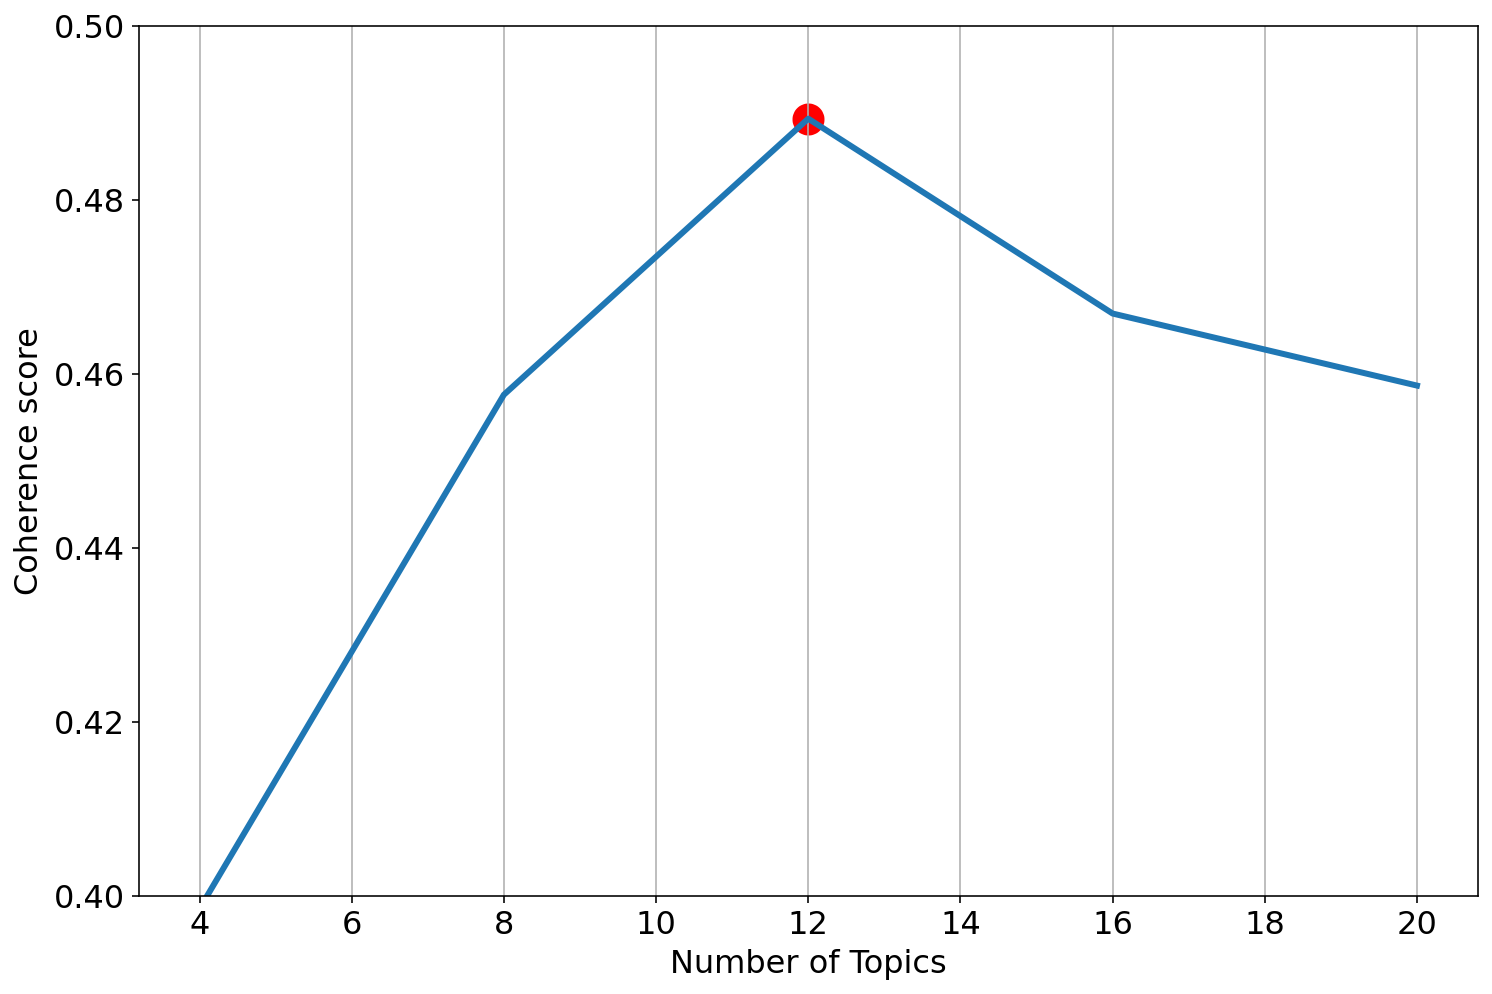

<Figure size 432x288 with 0 Axes>

In [75]:
max_arg = np.where(coherence_values == max(coherence_values))[0][0]
# Show graph
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
limit=24; start=4; step=4;
x = range(start, limit, step)
plt.scatter(x[max_arg],coherence_values[max_arg], c='red', linewidths=10)
plt.plot(x, coherence_values,LineWidth = 3)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.grid(axis='x')
plt.ylim((0.4,0.5))
#plt.annotate('Optimal Coherence Value',xy=(x[max_arg],coherence_values[max_arg]))
plt.show()
plt.savefig('/content/drive/MyDrive/plots_topic-coherence')

### Training of LDA Model

In [141]:
lda_model = model_list[2]
doc_lda = lda_model[corpus]
pprint(lda_model.print_topics())

[(0,
  '0.014*"target" + 0.012*"breast" + 0.012*"crispr" + 0.012*"cas" + '
  '0.009*"brca" + 0.005*"editing" + 0.005*"non" + 0.004*"development" + '
  '0.004*"methylation" + 0.004*"approach"'),
 (1,
  '0.022*"brca" + 0.020*"parp" + 0.012*"ku" + 0.009*"adp_ribose" + '
  '0.008*"target" + 0.006*"polymerase" + 0.005*"fa" + 0.005*"topoisomerase" + '
  '0.004*"inhibitor" + 0.004*"breast"'),
 (2,
  '0.021*"uv" + 0.007*"xp" + 0.007*"skin" + 0.007*"transcription" + '
  '0.006*"lesion" + 0.005*"ultraviolet" + 0.004*"adduct" + 0.004*"normal" + '
  '0.004*"oxidative" + 0.003*"formation"'),
 (3,
  '0.008*"escherichia" + 0.008*"reca" + 0.007*"plasmid" + 0.006*"lesion" + '
  '0.006*"glycosylase" + 0.006*"sos" + 0.004*"endonuclease" + 0.004*"strain" + '
  '0.004*"target" + 0.004*"product"'),
 (4,
  '0.013*"telomere" + 0.006*"hr" + 0.005*"pk" + 0.005*"nbs" + 0.004*"normal" + '
  '0.004*"helicase" + 0.004*"telomerase" + 0.004*"sensitivity" + '
  '0.004*"apoptosis" + 0.004*"phase"'),
 (5,
  '0.028*"rad"

## Analysis of Results

### What is the Dominant topic and its percentage contribution in each document?
In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [80]:
def format_topics_sentences(ldamodel=None, corpus = corpus, texts= texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


In [81]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

In [142]:
# Format
pd.options.display.max_colwidth = 100
df_dominant = df_topic_sents_keywords.reset_index()
df_dominant.columns = ['PMID', 'Dominant_Topic', 'Topic_%-Contribution', 'Keywords', 'Text']
df_dominant['Dominant_Topic'] = df_dominant['Dominant_Topic'].astype('int')
df_dominant['PMID'] = df['PMID']
df_dominant.head(12)

PMID  ...                                                                                                 Text
0   33581499  ...  [pcna, focus, telomere, maintenance, telomere, specialize, stretch, linear, crucial, step, immor...
1   33581339  ...  [compositional, variability, spectrum, monophyletic, sar, cov, clade, covid, causative, pathogen...
2   33580188  ...  [variant, dimer, spontaneously, exchange, canonical, nucleosome, variant, accumulate, region, ex...
3   33580181  ...  [hypermutated, phenotype, gliosarcoma, spinal_cord, gliosarcoma, variant, glioblastoma, equally,...
4   33580144  ...  [arsenic, hexoxide, differential, proliferation, wide, primary, mcf, arsenic, reportedly, biphas...
5   33579976  ...  [persistent, stag, multimodal, recurrent, pediatric, glioblastoma, adult, counterpart, prognosis...
6   33579974  ...  [somatic, aberration, benign, breast, subsequent, breast, largely_unknown, development, breast, ...
7   33579938  ...  [whole, datum, derive, deficiency, score, deficiency, hrd, score, develop, whole, copy_number, d...
8   33579867  ...  [fan, nuclease, modifier, disorder, fan, encode, nuclease, deficiency, copy_number, variant, var...
9   33579866  ...  [pathogenic, cag, expansion, length, huntington, huntington, hd, omim, expand, cag, repeat_tract...
10  33579865  ...  [huntington, mmr, stabilizing, correct, error, limit, rearrangement, mediate, many, mmr, generat...
11  33579863  ...  [contribution, somatic, expansion, cag, repeat, symptomatic, development, huntington, discovery,...

[12 rows x 5 columns]

In [84]:
save_csv('/content/drive/MyDrive/data','dominant_topics_',df_dominant)
#df_dominant = load_csv('/content/drive/MyDrive/data','dominant_topics')

Saving Dataframe to CSV


### Frequency Distribution of Word Counts in Documents

When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

<Figure size 1296x576 with 0 Axes>

(array([1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 6.000e+00,
        0.000e+00, 1.000e+01, 7.000e+00, 1.300e+01, 0.000e+00, 1.000e+01,
        2.300e+01, 0.000e+00, 2.800e+01, 3.900e+01, 0.000e+00, 4.600e+01,
        5.400e+01, 5.700e+01, 0.000e+00, 6.300e+01, 8.200e+01, 0.000e+00,
        1.070e+02, 9.600e+01, 1.290e+02, 0.000e+00, 1.100e+02, 1.330e+02,
        0.000e+00, 1.440e+02, 1.450e+02, 0.000e+00, 1.880e+02, 2.020e+02,
        2.190e+02, 0.000e+00, 2.320e+02, 2.500e+02, 0.000e+00, 2.380e+02,
        2.990e+02, 3.050e+02, 0.000e+00, 3.400e+02, 3.430e+02, 0.000e+00,
        3.920e+02, 4.450e+02, 0.000e+00, 4.550e+02, 4.520e+02, 4.850e+02,
        0.000e+00, 5.680e+02, 5.500e+02, 0.000e+00, 6.070e+02, 6.310e+02,
        6.480e+02, 0.000e+00, 6.800e+02, 7.230e+02, 0.000e+00, 7.510e+02,
        7.810e+02, 0.000e+00, 8.060e+02, 8.310e+02, 9.510e+02, 0.000e+00,
        9.570e+02, 9.340e+02, 0.000e+00, 1.038e+03, 1.017e+03, 0.000e+00,
        1.070e+03, 1.110e+03, 1.102e+0

Text(185, 1450, 'Mean   : 81')

Text(185, 1350, 'Median : 79')

Text(185, 1250, 'Stdev   : 29')

Text(185, 1150, '1% quantile    : 23')

Text(184, 1050, '99% quantile  : 162')

[Text(0, 0.5, 'Number of Documents'),
 (0.0, 225.0),
 Text(0.5, 0, 'Document Word Count')]

([<matplotlib.axis.XTick at 0x7f8a8573add8>,
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 1.0, 'Distribution of Document Word Counts')

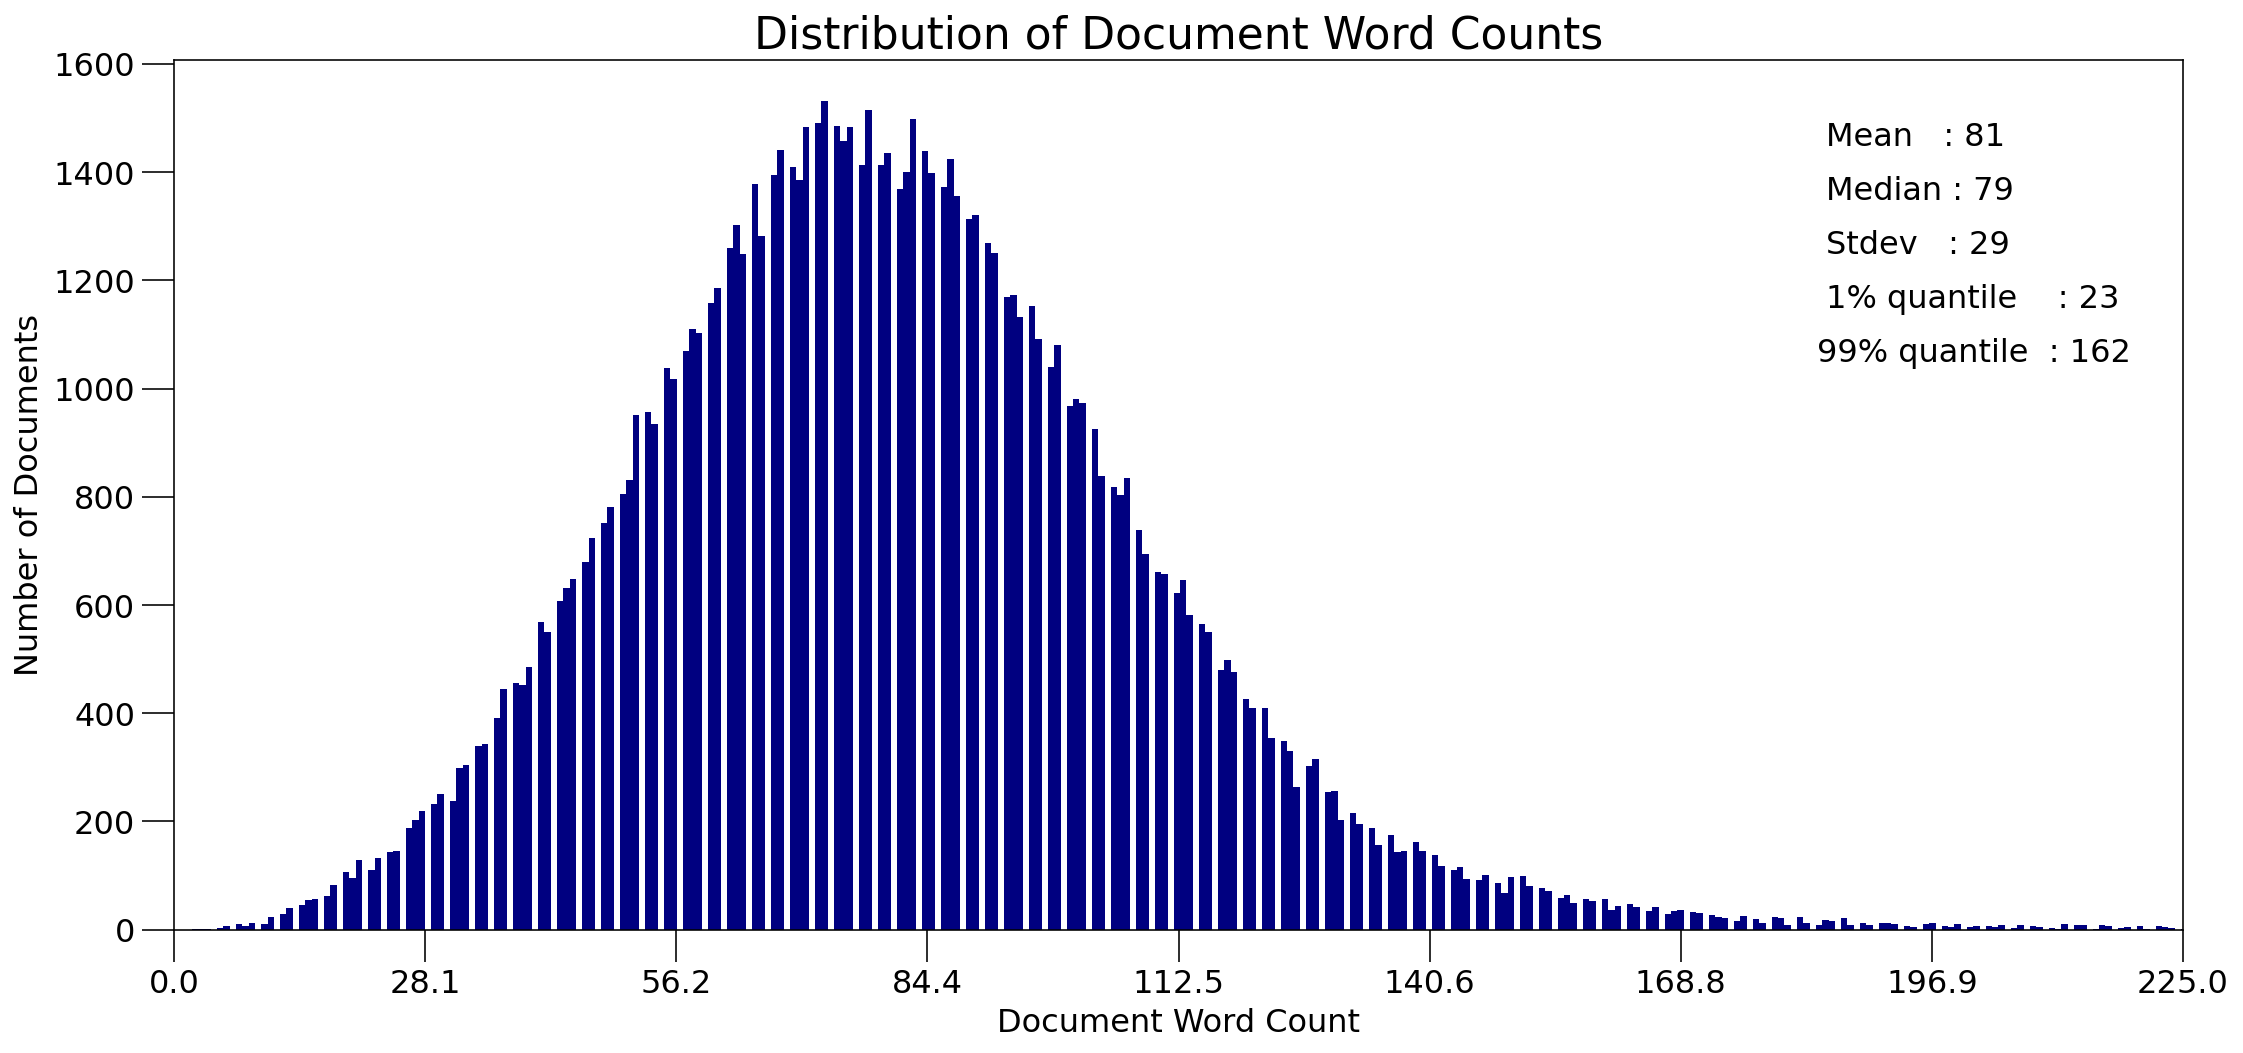

In [90]:
doc_lens = [len(d) for d in df_dominant.Text]

# Plot
plt.figure(figsize=(18,8))
plt.rcParams.update({'font.size': 16})
# plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(185, 1450, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(185,  1350, "Median : " + str(round(np.median(doc_lens))))
plt.text(185,  1250, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(185,  1150, "1% quantile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(184,  1050, "99% quantile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 225), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,225,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig('/content/drive/MyDrive/plots/distribution_word_counts.png')

(array([ 4.,  0.,  3.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  2.,  0.,  0.,  3.,  0.,  2.,  0.,  0.,  5.,  0.,  5.,
         0.,  0.,  3.,  0.,  0.,  6.,  0.,  7.,  0.,  0.,  2.,  0.,  5.,
         0.,  0.,  6.,  0.,  6.,  0.,  0.,  4.,  0.,  0.,  7.,  0., 11.,
         0.,  0., 12.,  0., 10.,  0.,  0.,  7.,  0.,  0., 18.,  0., 12.,
         0.,  0., 12.,  0., 14.,  0.,  0., 19.,  0., 12.,  0.,  0., 19.,
         0.,  0., 15.,  0., 18.,  0.,  0., 26.,  0., 33.,  0.,  0., 36.,
         0.,  0., 25.,  0., 36.,  0.,  0., 31.,  0., 38.,  0.,  0., 26.,
         0., 38.,  0.,  0., 33.,  0.,  0., 36.,  0., 42.,  0.,  0., 42.,
         0., 48.,  0.,  0., 39.,  0.,  0., 57.,  0., 53.,  0.,  0., 51.,
         0., 57.,  0.,  0., 61.,  0., 57.,  0.,  0., 64.,  0.,  0., 60.,
         0., 71.,  0.,  0., 88.,  0., 76.,  0.,  0., 96.,  0.,  0., 63.,
         0., 86.,  0.,  0., 80.,  0., 64.,  0.,  0., 70.,  0., 88.,  0.,
         0., 75.,  0.,  0., 78.,  0., 85.,  0.,  0.

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 0')

(array([  2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,
          0.,   2.,   0.,   0.,   3.,   0.,   6.,   0.,   8.,   0.,   5.,
          0.,   9.,   0.,  11.,   0.,  12.,   0.,   0.,   8.,   0.,   9.,
          0.,  18.,   0.,  15.,   0.,  24.,   0.,  28.,   0.,  21.,   0.,
          0.,  29.,   0.,  21.,   0.,  28.,   0.,  25.,   0.,  37.,   0.,
         30.,   0.,  39.,   0.,   0.,  33.,   0.,  43.,   0.,  53.,   0.,
         42.,   0.,  59.,   0.,  76.,   0.,  57.,   0.,   0.,  56.,   0.,
         61.,   0.,  71.,   0.,  59.,   0.,  88.,   0.,  64.,   0.,  67.,
          0.,   0.,  79.,   0.,  85.,   0., 106.,   0.,  72.,   0.,  94.,
          0., 102.,   0.,   0., 101.,   0.,  94.,   0., 109.,   0., 115.,
          0.,  95.,   0.,  99.,   0., 106.,   0.,   0., 132.,   0., 122.,
          0., 117.,   0., 126.,   0., 137.,   0., 120.,   0., 118.,   0.,
          0., 124.,   0., 121.,   0., 126.,   0., 121.,   0., 132.,   0.,
        118.,   0., 139.,   0.,   0., 

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 1')

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   2.,   0.,   0.,   4.,   0.,   0.,   5.,   0.,
          5.,   0.,   0.,   9.,   0.,   8.,   0.,   0.,   5.,   0.,   0.,
          7.,   0.,  10.,   0.,   0.,  12.,   0.,   4.,   0.,   0.,  17.,
          0.,   8.,   0.,   0.,  18.,   0.,   0.,  18.,   0.,  20.,   0.,
          0.,  21.,   0.,  21.,   0.,   0.,  30.,   0.,   0.,  29.,   0.,
         36.,   0.,   0.,  39.,   0.,  35.,   0.,   0.,  30.,   0.,   0.,
         49.,   0.,  52.,   0.,   0.,  38.,   0.,  55.,   0.,   0.,  47.,
          0.,   0.,  61.,   0.,  53.,   0.,   0.,  65.,   0.,  55.,   0.,
          0.,  66.,   0.,  80.,   0.,   0.,  68.,   0.,   0.,  63.,   0.,
         76.,   0.,   0.,  89.,   0.,  87.,   0.,   0.,  94.,   0.,   0.,
         94.,   0.,  95.,   0.,   0.,  94.,   0.,  85.,   0.,   0., 104.,
          0.,   0., 111.,   0., 121., 

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 2')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   2.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   1.,   0.,   6.,   0.,   0.,   6.,   0.,   0.,   4.,   0.,
         10.,   0.,   0.,   5.,   0.,  12.,   0.,   0.,  15.,   0.,   0.,
         13.,   0.,  19.,   0.,   0.,  24.,   0.,  15.,   0.,   0.,  19.,
          0.,   0.,  15.,   0.,  23.,   0.,   0.,  30.,   0.,  27.,   0.,
          0.,  42.,   0.,   0.,  34.,   0.,  19.,   0.,   0.,  45.,   0.,
         47.,   0.,   0.,  42.,   0.,   0.,  45.,   0.,  50.,   0.,   0.,
         40.,   0.,  57.,   0.,   0.,  53.,   0.,   0.,  60.,   0.,  80.,
          0.,   0.,  91.,   0.,  72.,   0.,   0.,  90.,   0.,   0.,  81.,
          0.,  86.,   0.,   0.,  98.,   0.,  93.,   0.,   0.,  83.,   0.,
          0.,  96.,   0.,  99.,   0.,   0., 111.,   0., 140.,   0.,   0.,
        115.,   0.,   0., 114.,   0., 127.,   0.,   0., 127.,   0., 122.,
          0.,   0., 137.,   0.,   0., 

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 3')

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  3.,
         0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  4.,  0.,
         0.,  0.,  6.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  6.,
         0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,
         3.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,
         0.,  0., 16.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0., 11.,  0.,
         0.,  0.,  0., 13.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0., 11.,
         0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,
         0., 14.,  0.,  0.,  0., 22.,  0.,  0.,  0.,  0., 19.,  0.,  0.,
         0.,  0., 16.,  0.,  0.,  0.,  0., 11.,  0.

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 4')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   4.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   4.,
          0.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,  11.,   0.,
          0.,   0.,   8.,   0.,   0.,   0.,   0.,  13.,   0.,   0.,   0.,
          0.,  17.,   0.,   0.,   0.,  24.,   0.,   0.,   0.,   0.,  20.,
          0.,   0.,   0.,   0.,  20.,   0.,   0.,   0.,  20.,   0.,   0.,
          0.,   0.,  19.,   0.,   0.,   0.,   0.,  20.,   0.,   0.,   0.,
         21.,   0.,   0.,   0.,   0.,  27.,   0.,   0.,   0.,   0.,  28.,
          0.,   0.,   0.,  31.,   0.,   0.,   0.,   0.,  31.,   0.,   0.,
          0.,   0.,  32.,   0.,   0.,   0.,  40.,   0.,   0.,   0.,   0.,
         35.,   0.,   0.,   0.,   0.,  42.,   0.,   0.,   0.,  49.,   0.,
          0.,   0.,   0.,  40.,   0.,   0.,   0.,   0.,  57.,   0.,   0.,
          0.,  62.,   0.,   0.,   0., 

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 5')

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   4.,   1.,   0.,
          2.,   3.,   0.,   1.,   2.,   0.,   5.,   6.,   5.,   0.,   5.,
          9.,   0.,   5.,  11.,   0.,  13.,   9.,   7.,   0.,  12.,  13.,
          0.,  17.,  15.,   0.,  17.,  26.,  22.,   0.,  27.,  22.,   0.,
         43.,  33.,   0.,  35.,  34.,  39.,   0.,  42.,  41.,   0.,  51.,
         55.,  50.,   0.,  48.,  48.,   0.,  56.,  65.,   0.,  53.,  53.,
         65.,   0.,  73.,  58.,   0.,  75.,  83.,   0.,  80.,  82.,  72.,
          0.,  90.,  91.,   0.,  87., 108.,   0.,  88.,  98.,  91.,   0.,
         91., 101.,   0., 100., 102.,   0., 117., 122., 142.,   0., 112.,
        138.,   0., 134., 125., 150.,   0., 129., 132.,   0., 130., 128.,
          0., 147., 147., 152.,   0., 129., 140.,   0., 114., 133.,   0.,
        145., 134., 142.,   0., 107., 133.,   0., 125., 125.,   0., 135.,
        123., 118.,   0., 125., 113.,   0., 114., 121.,   0., 100.,  94.,
        106.,   0., 111., 105.,   0., 

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 6')

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   2.,   0.,   0.,   2.,   0.,   0.,   3.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,
          1.,   0.,   0.,   3.,   0.,   0.,   1.,   0.,   0.,   5.,   0.,
          0.,   6.,   0.,   0.,   9.,   0.,   0.,   7.,   0.,   0.,   6.,
          0.,   0.,   7.,   0.,   0.,  13.,   0.,   0.,   8.,   0.,   0.,
         15.,   0.,   0.,  12.,   0.,   0.,  11.,   0.,   0.,  17.,   0.,
          0.,  22.,   0.,   0.,  25.,   0.,   0.,   9.,   0.,   0.,  23.,
          0.,   0.,  22.,   0.,   0.,  24.,   0.,   0.,  33.,   0.,   0.,
         19.,   0.,   0.,  31.,   0.,   0.,  34.,   0.,   0.,  31.,   0.,
          0.,  50.,   0.,   0.,  43.,   0.,   0.,  48.,   0.,   0.,  46.,
          0.,   0.,  51.,   0.,   0.,  68.,   0.,   0.,  57.,   0.,   0.,
         63.,   0.,   0.,  58.,   0., 

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 7')

(array([  1.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   3.,   0.,   6.,
          0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   4.,   0.,
          8.,   0.,   5.,   0.,   0.,   7.,   0.,   7.,   0.,   0.,  10.,
          0.,   8.,   0.,   3.,   0.,   0.,   7.,   0.,  12.,   0.,   0.,
         12.,   0.,  19.,   0.,  16.,   0.,   0.,  26.,   0.,  17.,   0.,
          0.,   8.,   0.,  20.,   0.,  26.,   0.,   0.,  24.,   0.,  28.,
          0.,   0.,  28.,   0.,  22.,   0.,  31.,   0.,   0.,  27.,   0.,
         31.,   0.,   0.,  31.,   0.,  39.,   0.,  46.,   0.,   0.,  45.,
          0.,  37.,   0.,   0.,  47.,   0.,  44.,   0.,  47.,   0.,   0.,
         47.,   0.,  50.,   0.,   0.,  50.,   0.,  57.,   0.,  47.,   0.,
          0.,  50.,   0.,  64.,   0.,   0.,  52.,   0.,  75.,   0.,  79.,
          0.,   0.,  76.,   0.,  72.,   0.,   0.,  77.,   0.,  77.,   0.,
         84.,   0.,   0.,  93.,   0., 

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 8')

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  3.,  0.,  0.,  4.,
         0.,  0.,  0.,  5.,  0.,  0.,  0.,  9.,  0.,  0.,  0., 13.,  0.,
         0.,  0., 11.,  0.,  0.,  5.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,
         7.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  9.,
         0.,  0., 12.,  0.,  0.,  0., 14.,  0.,  0.,  0., 11.,  0.,  0.,
         0., 14.,  0.,  0.,  0., 14.,  0.,  0., 12.,  0.,  0.,  0., 20.,
         0.,  0.,  0.,  9.,  0.,  0.,  0., 21.,  0.,  0.,  0., 12.,  0.,
         0.,  0., 19.,  0.,  0., 17.,  0.,  0.,  0., 29.,  0.,  0.,  0.,
        38.,  0.,  0.,  0., 25.,  0.,  0.,  0., 36.,  0.,  0., 16.,  0.,
         0.,  0., 33.,  0.,  0.,  0., 37.,  0.,  0.

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 9')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   1.,
          0.,   0.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,   5.,   0.,
          0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   4.,   0.,   0.,
          0.,   2.,   0.,   0.,   6.,   0.,   0.,   0.,   4.,   0.,   0.,
          5.,   0.,   0.,   0.,   8.,   0.,   0.,   9.,   0.,   0.,   9.,
          0.,   0.,   0.,   4.,   0.,   0.,  10.,   0.,   0.,   0.,   4.,
          0.,   0.,  11.,   0.,   0.,   0.,   4.,   0.,   0.,   9.,   0.,
          0.,   0.,  12.,   0.,   0.,  16.,   0.,   0.,  14.,   0.,   0.,
          0.,  25.,   0.,   0.,  17.,   0.,   0.,   0.,  21.,   0.,   0.,
         19.,   0.,   0.,   0.,  25.,   0.,   0.,  13.,   0.,   0.,  21.,
          0.,   0.,   0.,  29.,   0.,   0.,  23.,   0.,   0.,   0.,  42.,
          0.,   0.,  27.,   0.,   0.,   0.,  28.,   0.,   0.,  19.,   0.,
          0.,   0.,  38.,   0.,   0.,  32.,   0.,   0.,  35.,   0.,   0.,
          0.,  41.,   0.,   0.,  45., 

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 10')

(array([  1.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   3.,   0.,   3.,
          0.,   0.,   6.,   0.,   0.,  11.,   0.,   0.,   7.,   0.,  13.,
          0.,   0.,  14.,   0.,   0.,  10.,   0.,  11.,   0.,   0.,  20.,
          0.,   0.,  26.,   0.,   0.,  22.,   0.,  29.,   0.,   0.,  18.,
          0.,   0.,  25.,   0.,  32.,   0.,   0.,  28.,   0.,   0.,  44.,
          0.,   0.,  39.,   0.,  45.,   0.,   0.,  54.,   0.,   0.,  51.,
          0.,  49.,   0.,   0.,  67.,   0.,   0.,  63.,   0.,   0.,  73.,
          0.,  79.,   0.,   0.,  68.,   0.,   0.,  94.,   0.,  87.,   0.,
          0.,  88.,   0.,   0., 103.,   0.,   0., 111.,   0.,  98.,   0.,
          0., 118.,   0.,   0., 100.,   0., 118.,   0.,   0., 122.,   0.,
          0., 124.,   0.,   0., 135.,   0., 130.,   0.,   0., 134.,   0.,
          0., 159.,   0.,   0., 156.,   0., 146.,   0.,   0., 155.,   0.,
          0., 165.,   0., 164.,   0.,   0., 152.,   0.,   0., 188.,   0.,
          0., 161.,   0., 171.,   0., 

[(0.0, 200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 11')

Text(0.5, 0.98, 'Distribution of Document Word Counts by Dominant Topic')

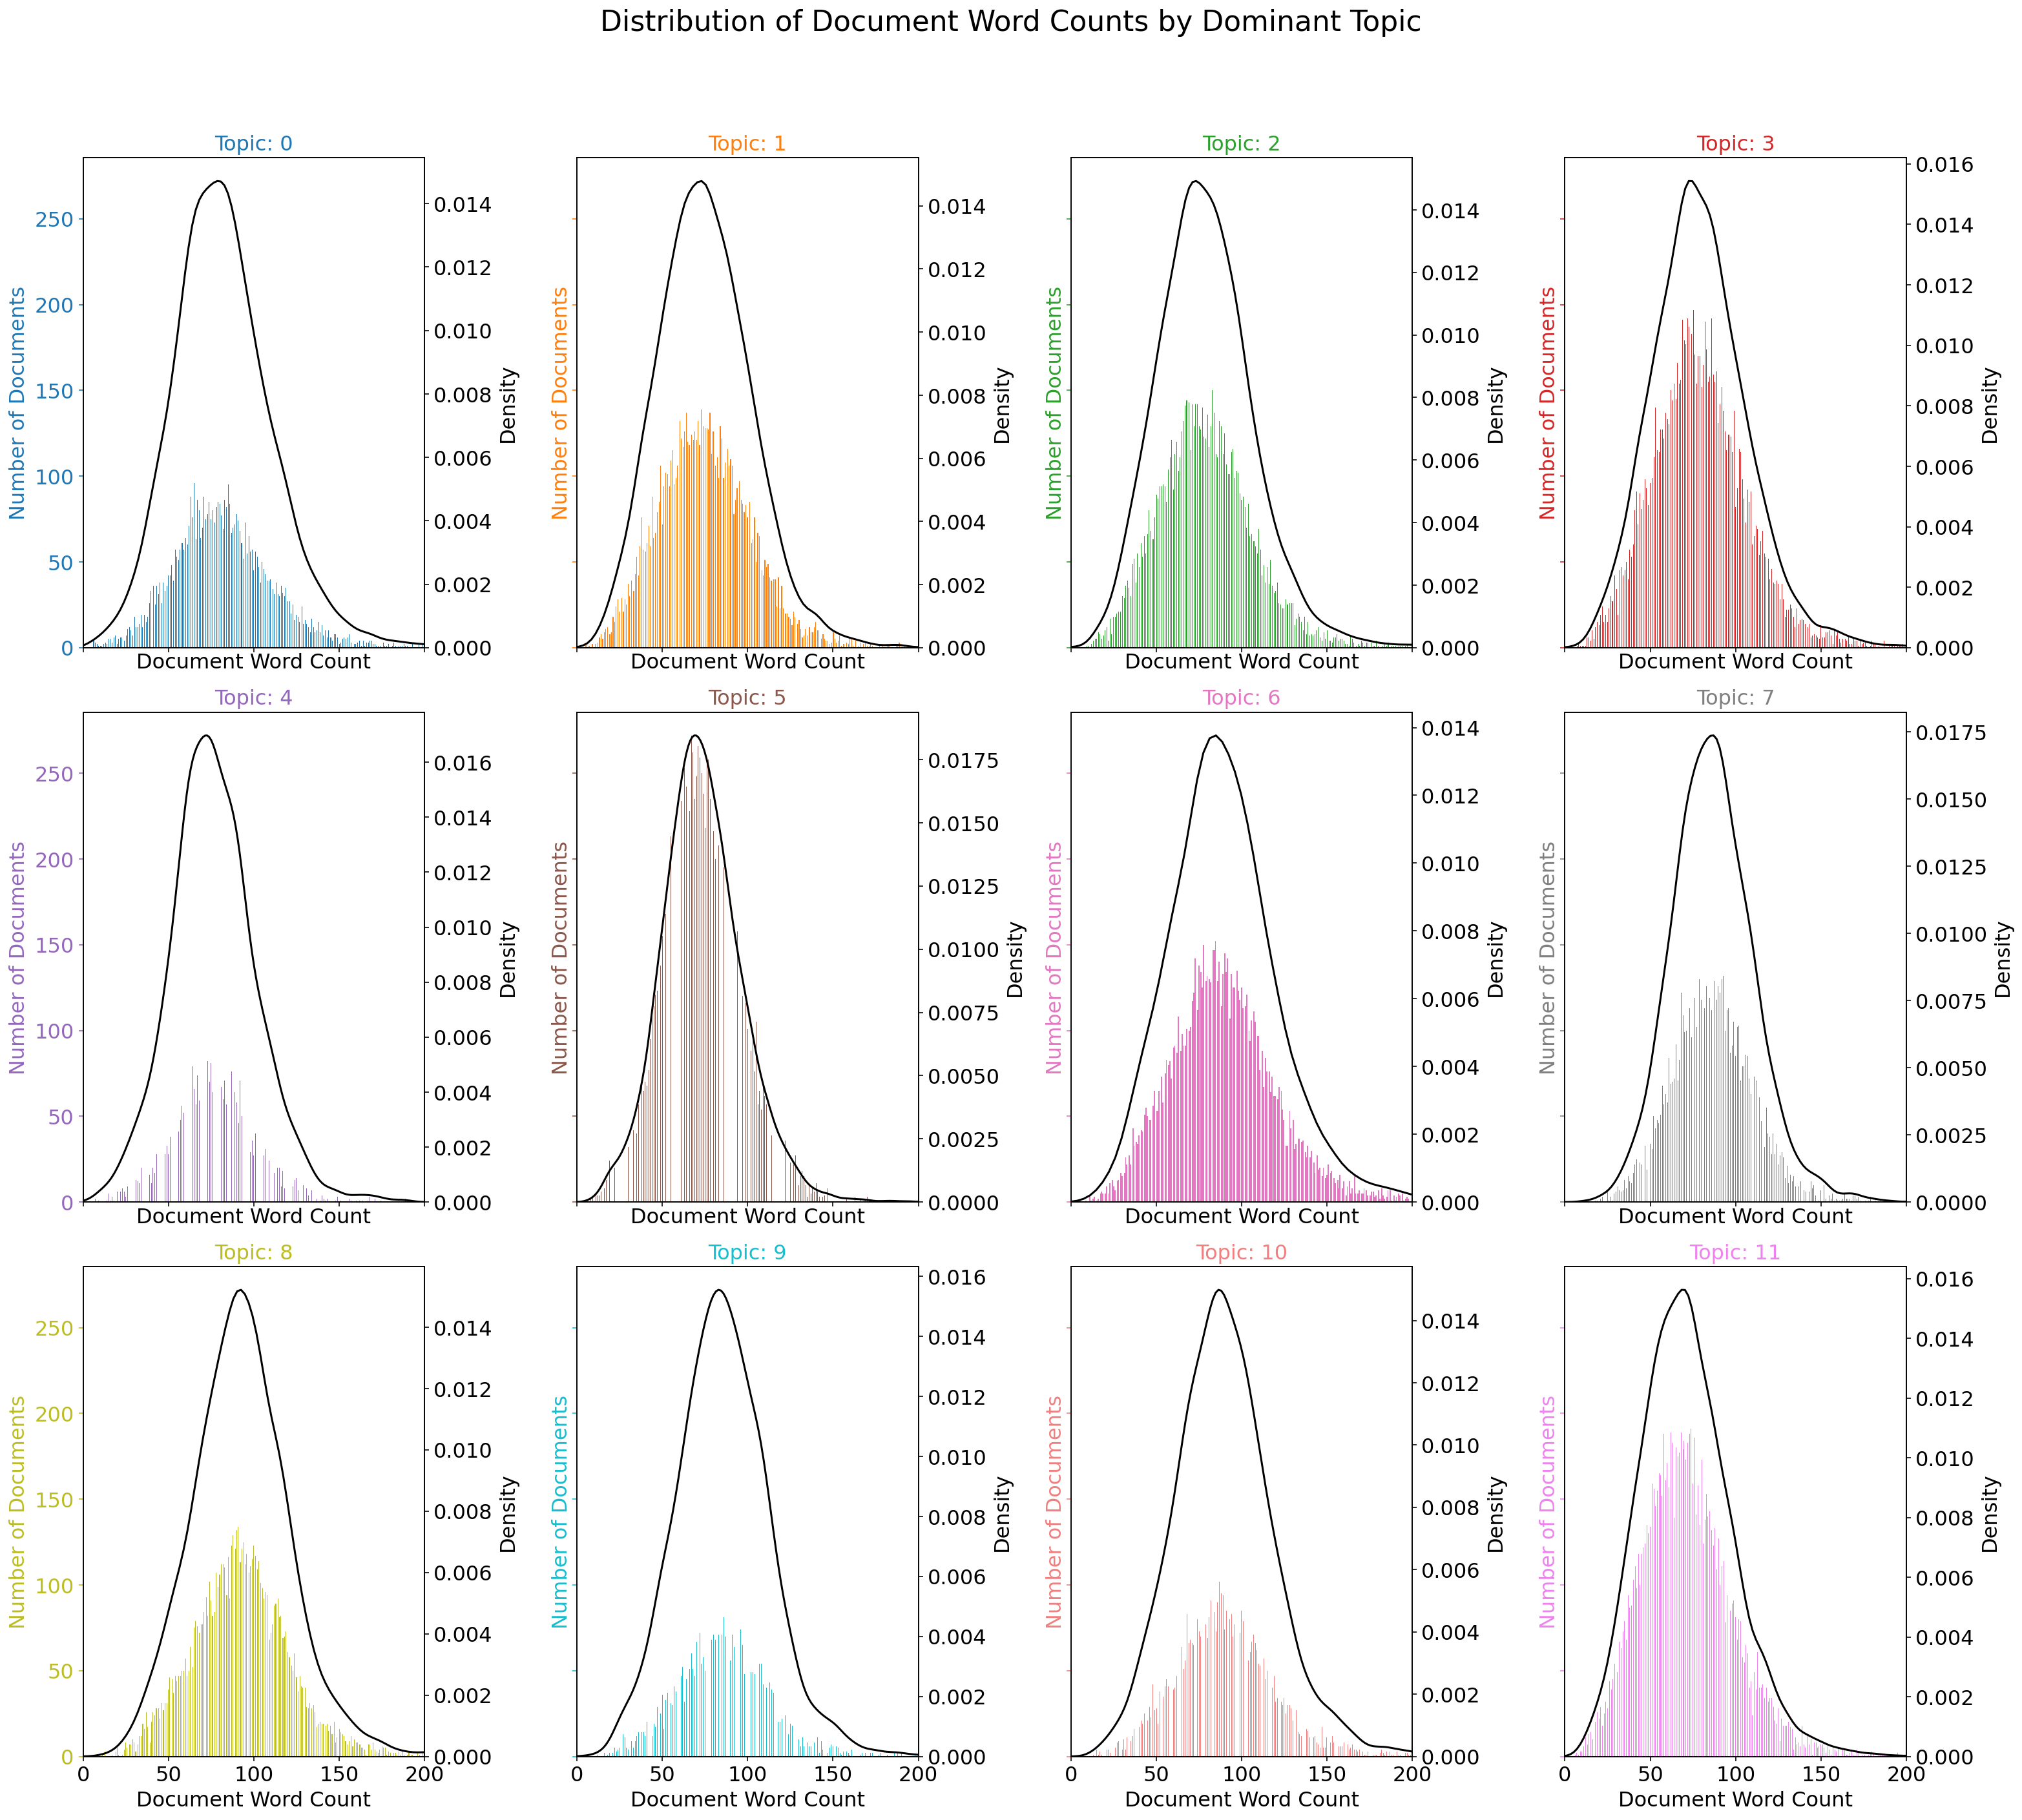

In [102]:
fig, axes = plt.subplots(3,4,figsize=(22,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_sub = df_dominant.loc[df_dominant['Dominant_Topic'] == i, :]
    doc_lens = [len(d) for d in df_dominant_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 200), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.savefig('/content/drive/MyDrive/plots/distribution_word_topic.png')
plt.show()

### Word Clouds of Top N Keywords in Each Topic

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 3')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 4')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 5')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 6')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 7')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 8')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 9')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 10')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 11')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

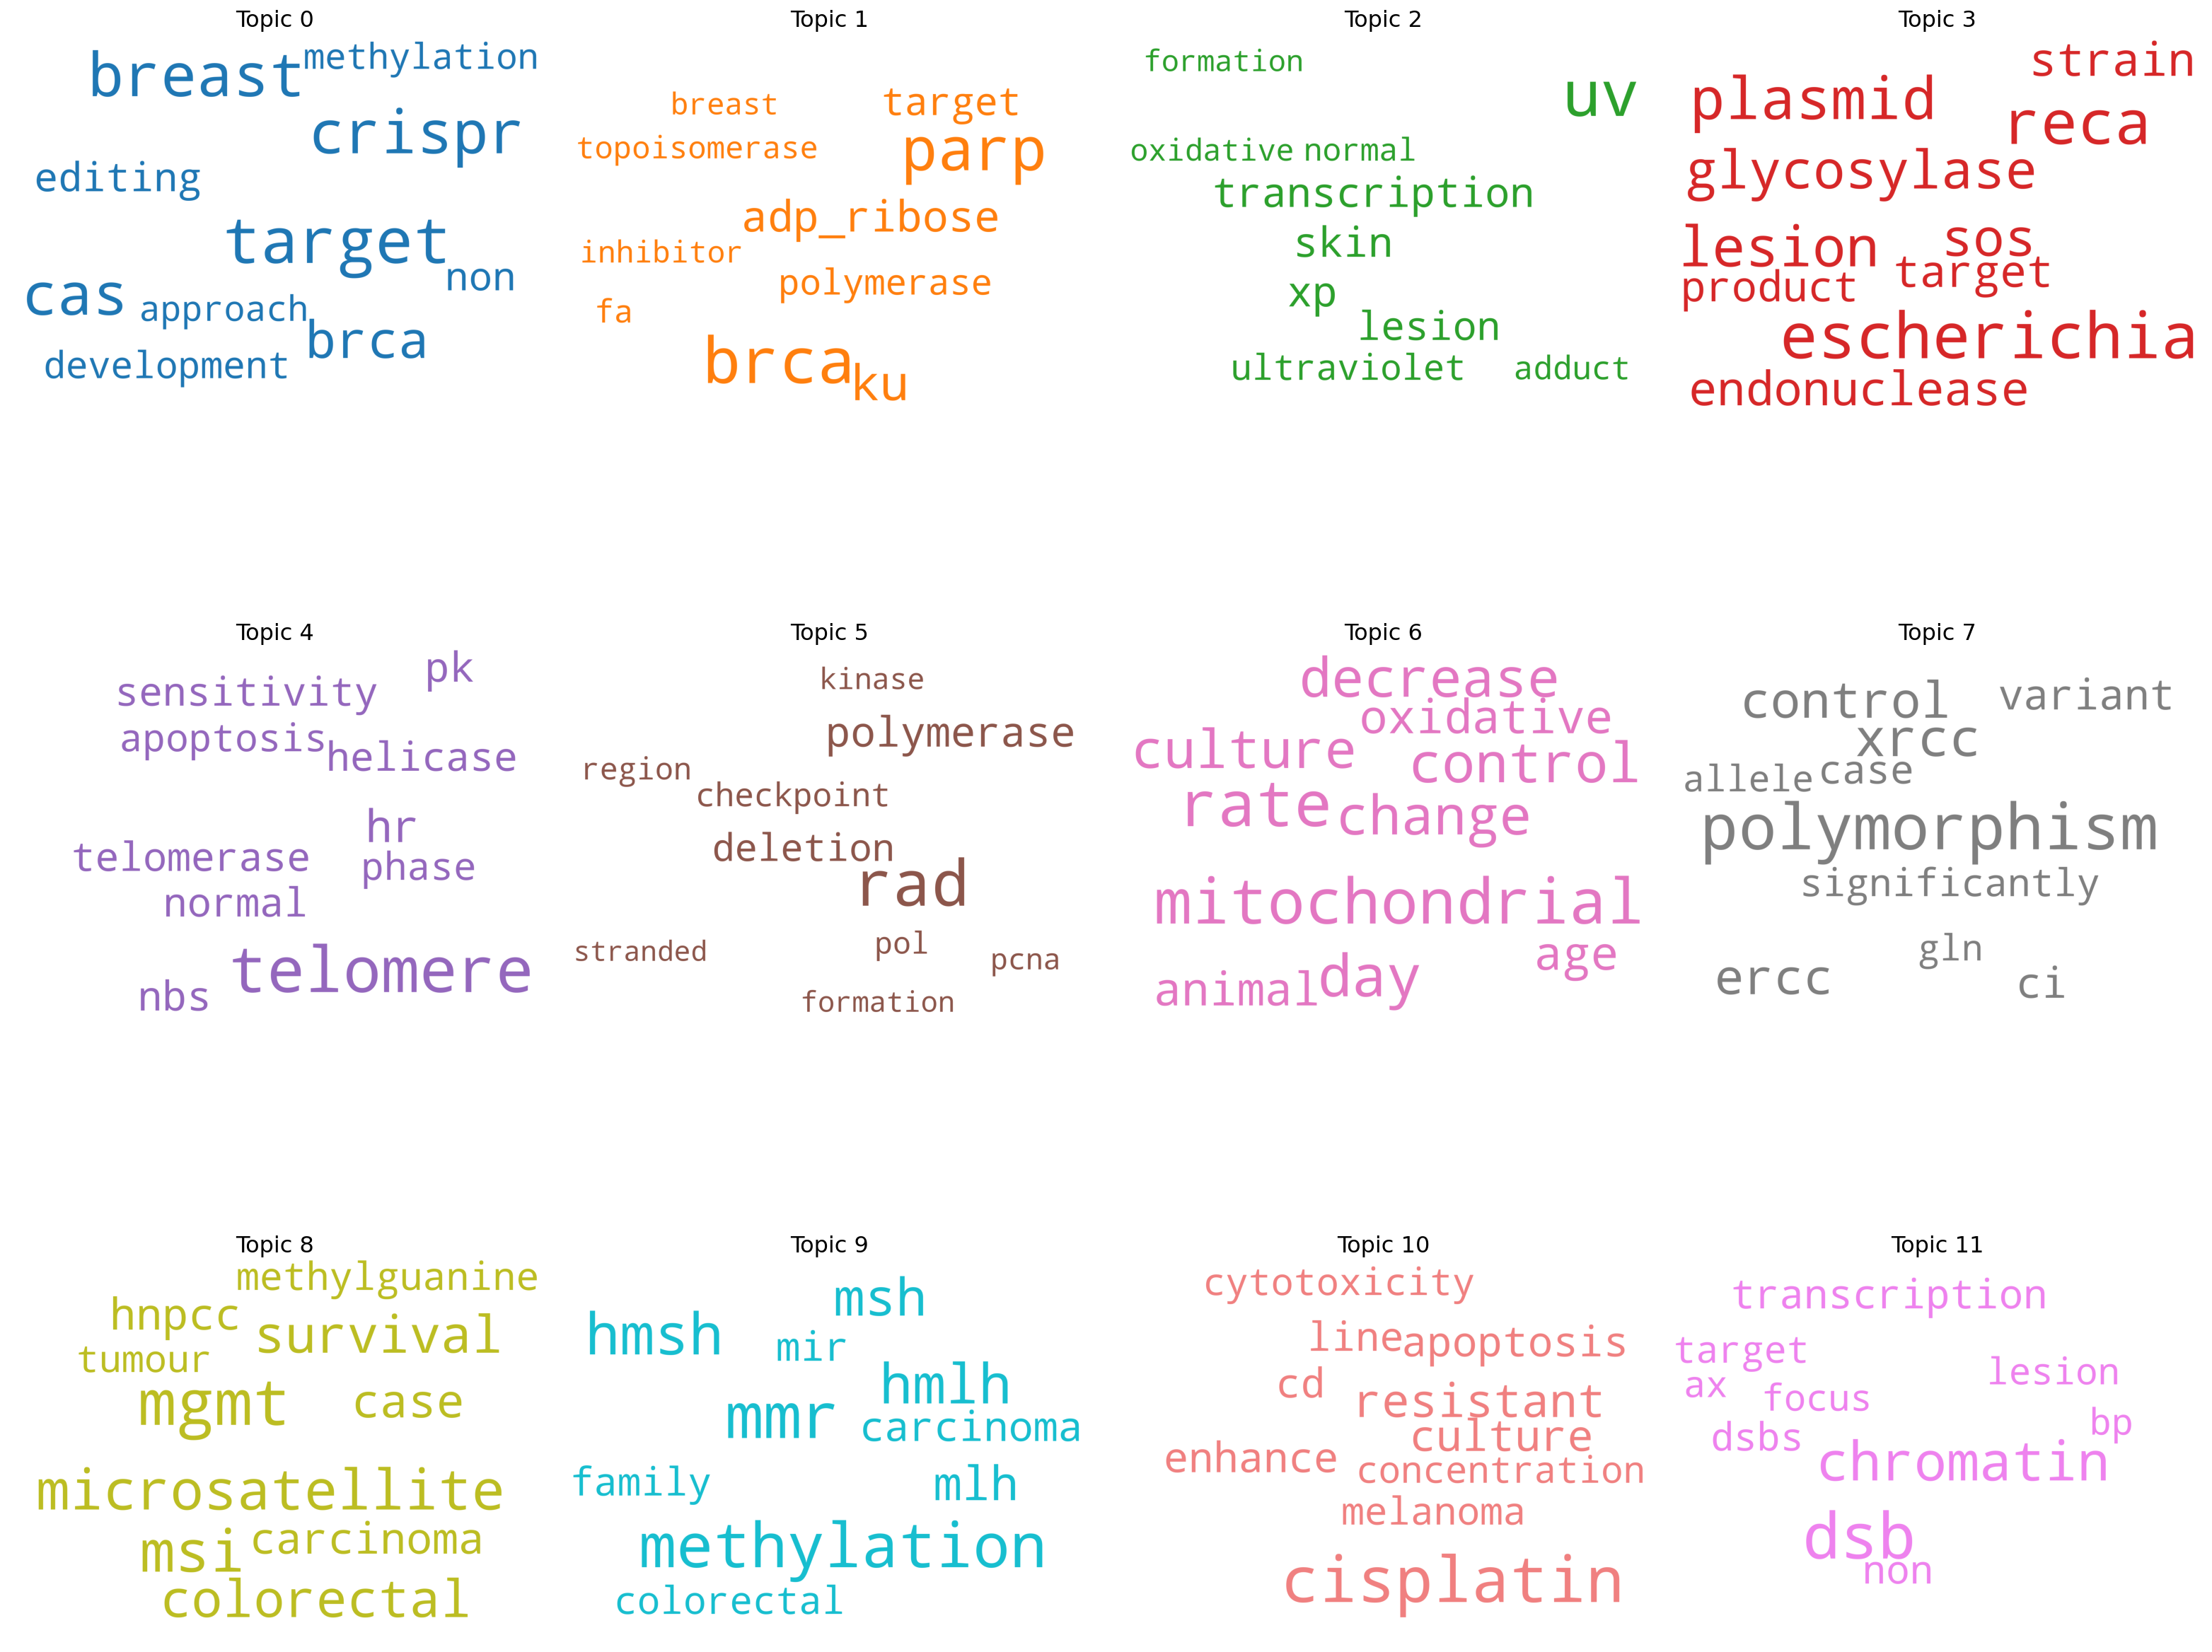

In [150]:
cloud_stopwords = ['radiation','strains','chromosome','break','sequence','mutant','however','frequency','synthesis','mutagenic','mutagenesis',
                   'trnscriptor','replication','dependent','mutation','genome','chromosme','dependent','syndrome','radiation','effects','inhibition''stranded',
                   'genome','non','target','formation','checkpoint','age','animal','decrease','day','change','product','strain','development','approach',
                   'decrease','editing','breast']
stopwords.extend(cloud_stopwords)

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=12,formatted=False)

plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(3,4,figsize=(22,20), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

from collections import Counter

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, 'target'),
 Text(0, 0, 'breast'),
 Text(0, 0, 'crispr'),
 Text(0, 0, 'cas'),
 Text(0, 0, 'brca'),
 Text(0, 0, 'editing'),
 Text(0, 0, 'non'),
 Text(0, 0, 'development'),
 Text(0, 0, 'methylation'),
 Text(0, 0, 'approach')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, 'brca'),
 Text(0, 0, 'parp'),
 Text(0, 0, 'ku'),
 Text(0, 0, 'adp_ribose'),
 Text(0, 0, 'target'),
 Text(0, 0, 'polymerase'),
 Text(0, 0, 'fa'),
 Text(0, 0, 'topoisomerase'),
 Text(0, 0, 'inhibitor'),
 Text(0, 0, 'breast')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, 'uv'),
 Text(0, 0, 'xp'),
 Text(0, 0, 'skin'),
 Text(0, 0, 'transcription'),
 Text(0, 0, 'lesion'),
 Text(0, 0, 'ultraviolet'),
 Text(0, 0, 'adduct'),
 Text(0, 0, 'normal'),
 Text(0, 0, 'oxidative'),
 Text(0, 0, 'formation')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, 'escherichia'),
 Text(0, 0, 'reca'),
 Text(0, 0, 'plasmid'),
 Text(0, 0, 'lesion'),
 Text(0, 0, 'glycosylase'),
 Text(0, 0, 'sos'),
 Text(0, 0, 'endonuclease'),
 Text(0, 0, 'strain'),
 Text(0, 0, 'target'),
 Text(0, 0, 'product')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 4')

[Text(0, 0, 'telomere'),
 Text(0, 0, 'hr'),
 Text(0, 0, 'pk'),
 Text(0, 0, 'nbs'),
 Text(0, 0, 'normal'),
 Text(0, 0, 'helicase'),
 Text(0, 0, 'telomerase'),
 Text(0, 0, 'sensitivity'),
 Text(0, 0, 'apoptosis'),
 Text(0, 0, 'phase')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 5')

[Text(0, 0, 'rad'),
 Text(0, 0, 'polymerase'),
 Text(0, 0, 'deletion'),
 Text(0, 0, 'checkpoint'),
 Text(0, 0, 'region'),
 Text(0, 0, 'pol'),
 Text(0, 0, 'pcna'),
 Text(0, 0, 'kinase'),
 Text(0, 0, 'formation'),
 Text(0, 0, 'stranded')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 6')

[Text(0, 0, 'rate'),
 Text(0, 0, 'mitochondrial'),
 Text(0, 0, 'day'),
 Text(0, 0, 'control'),
 Text(0, 0, 'decrease'),
 Text(0, 0, 'change'),
 Text(0, 0, 'culture'),
 Text(0, 0, 'oxidative'),
 Text(0, 0, 'age'),
 Text(0, 0, 'animal')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 7')

[Text(0, 0, 'polymorphism'),
 Text(0, 0, 'xrcc'),
 Text(0, 0, 'control'),
 Text(0, 0, 'ercc'),
 Text(0, 0, 'ci'),
 Text(0, 0, 'variant'),
 Text(0, 0, 'case'),
 Text(0, 0, 'significantly'),
 Text(0, 0, 'allele'),
 Text(0, 0, 'gln')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 8')

[Text(0, 0, 'mgmt'),
 Text(0, 0, 'msi'),
 Text(0, 0, 'microsatellite'),
 Text(0, 0, 'colorectal'),
 Text(0, 0, 'survival'),
 Text(0, 0, 'case'),
 Text(0, 0, 'hnpcc'),
 Text(0, 0, 'carcinoma'),
 Text(0, 0, 'methylguanine'),
 Text(0, 0, 'tumour')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 9')

[Text(0, 0, 'mmr'),
 Text(0, 0, 'methylation'),
 Text(0, 0, 'hmsh'),
 Text(0, 0, 'hmlh'),
 Text(0, 0, 'msh'),
 Text(0, 0, 'mlh'),
 Text(0, 0, 'carcinoma'),
 Text(0, 0, 'mir'),
 Text(0, 0, 'family'),
 Text(0, 0, 'colorectal')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 10')

[Text(0, 0, 'cisplatin'),
 Text(0, 0, 'resistant'),
 Text(0, 0, 'culture'),
 Text(0, 0, 'apoptosis'),
 Text(0, 0, 'enhance'),
 Text(0, 0, 'cd'),
 Text(0, 0, 'line'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'cytotoxicity'),
 Text(0, 0, 'concentration')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 11')

[Text(0, 0, 'dsb'),
 Text(0, 0, 'chromatin'),
 Text(0, 0, 'transcription'),
 Text(0, 0, 'non'),
 Text(0, 0, 'dsbs'),
 Text(0, 0, 'target'),
 Text(0, 0, 'lesion'),
 Text(0, 0, 'focus'),
 Text(0, 0, 'ax'),
 Text(0, 0, 'bp')]

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

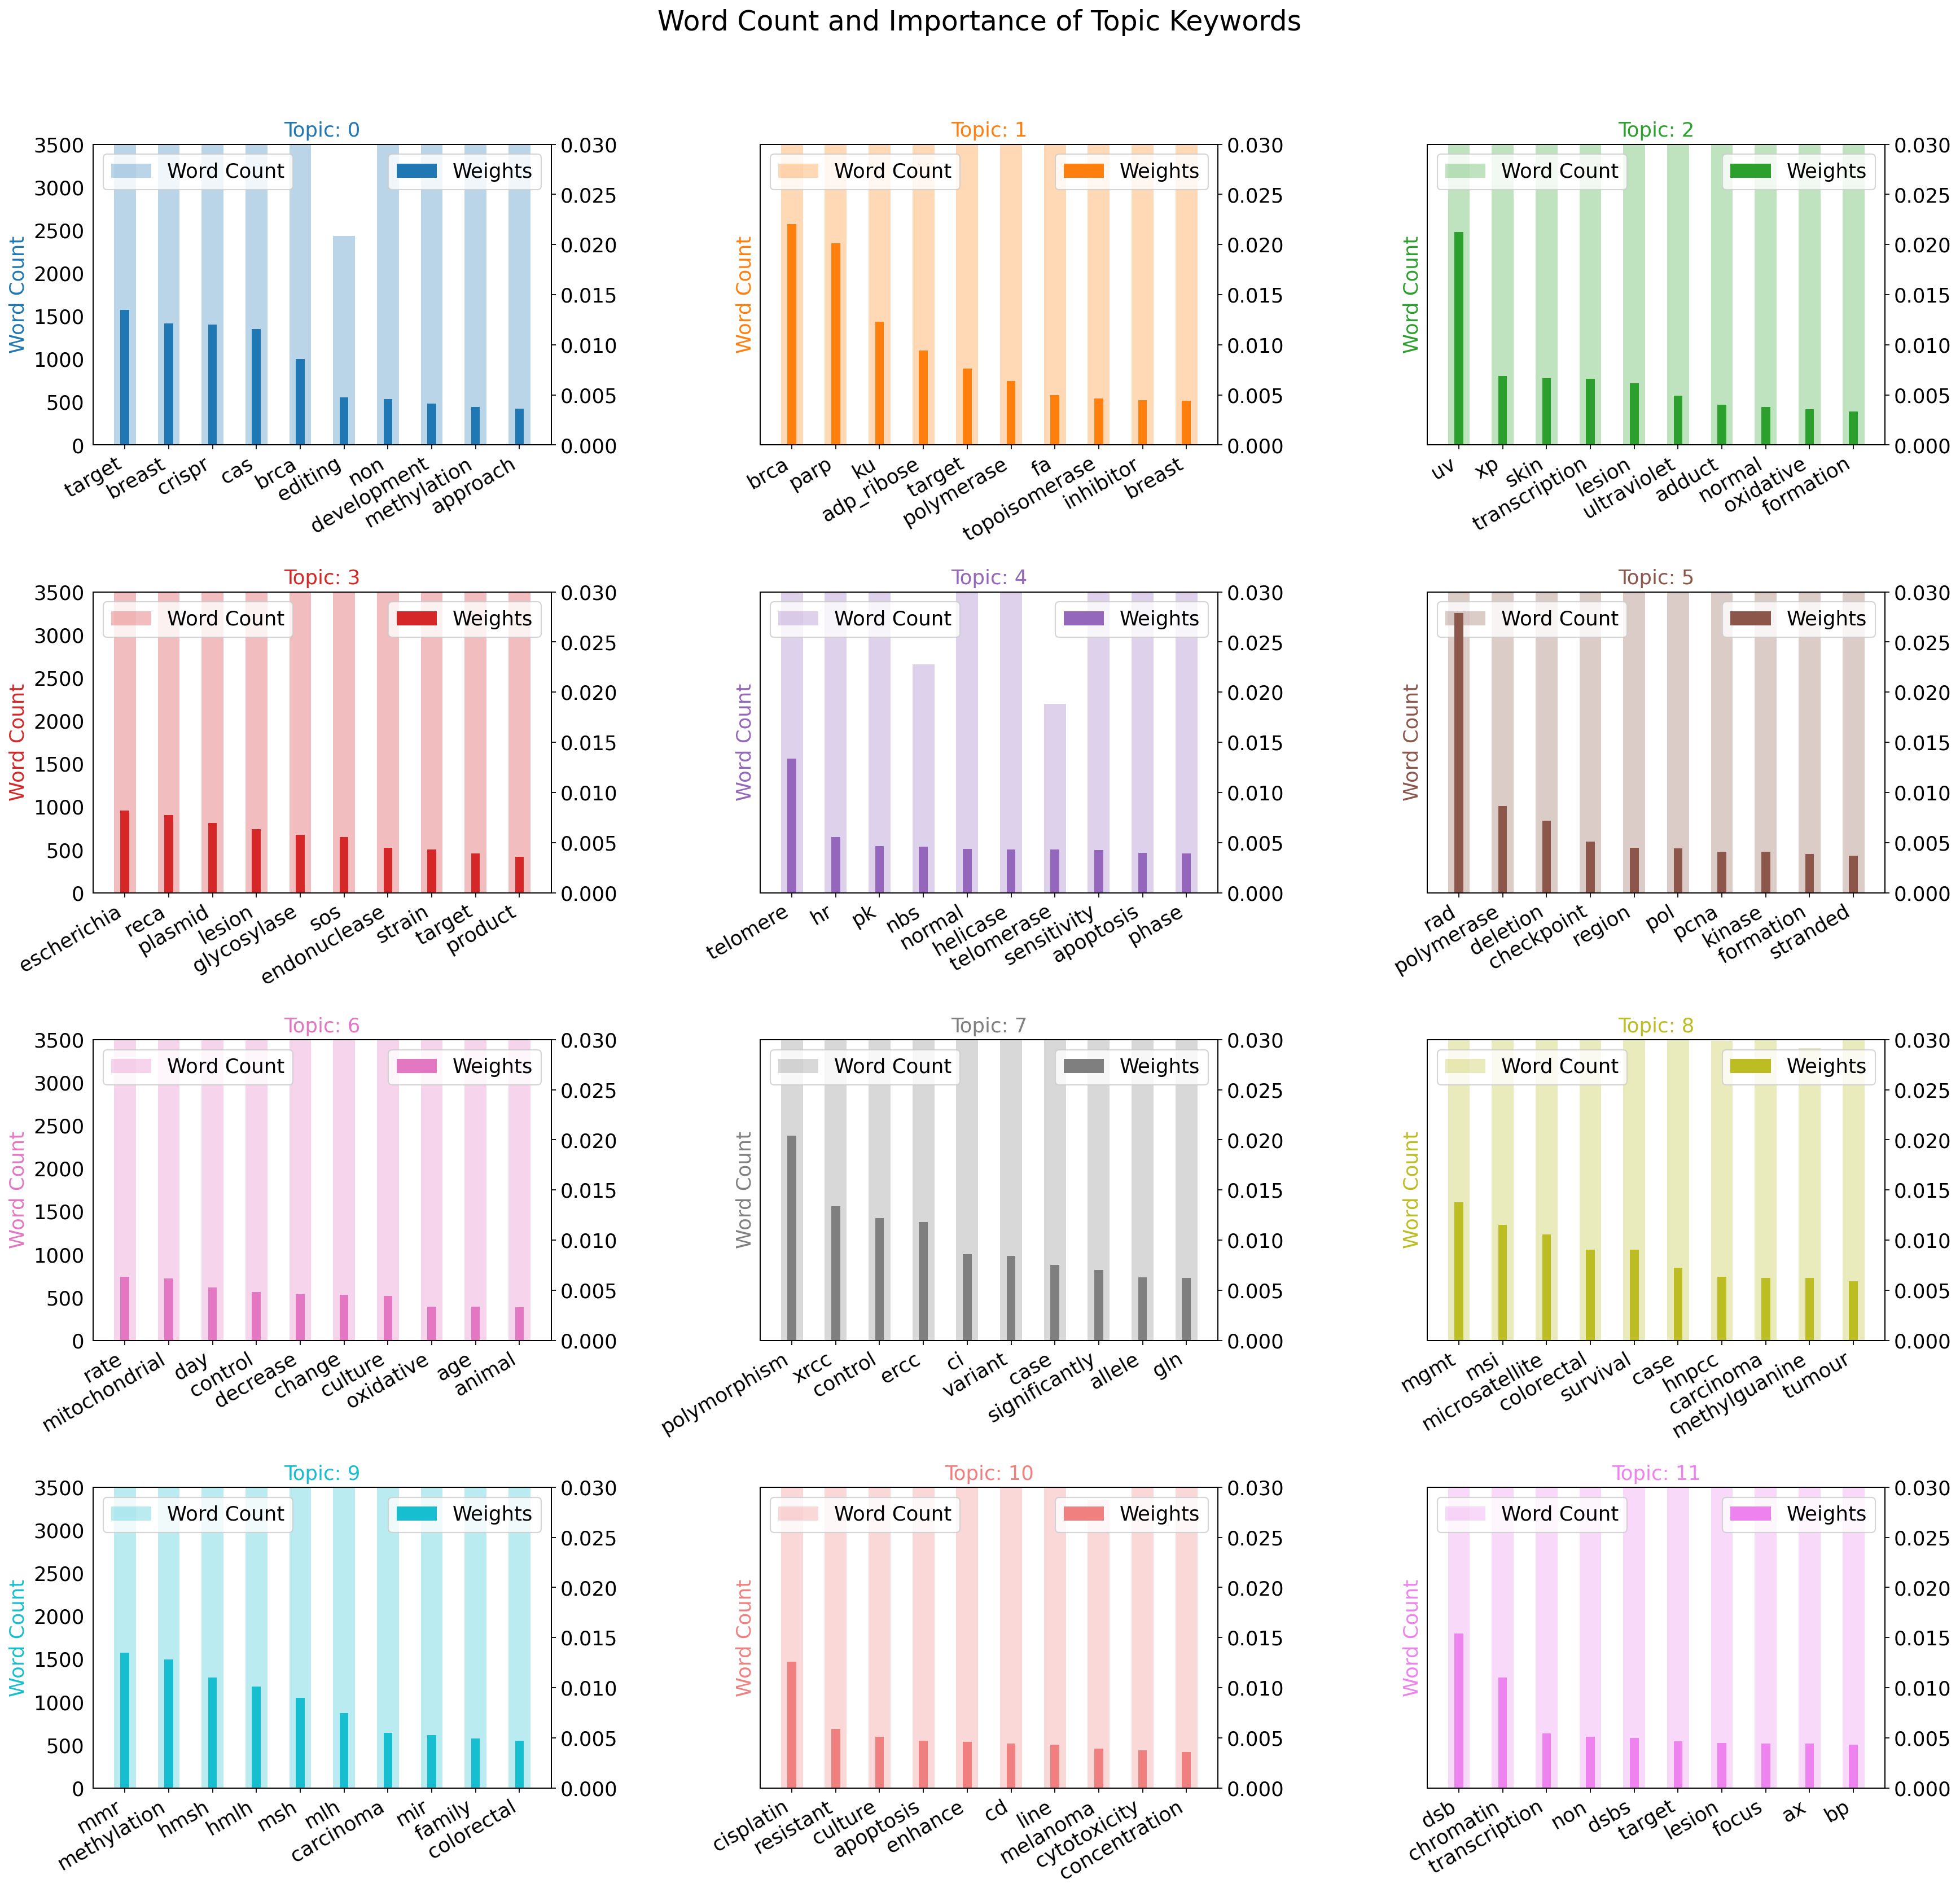

In [155]:
from collections import Counter
topics = lda_model.show_topics(num_topics=12,formatted=False)
data_flat = [w for w_list in tokens for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 3, figsize=(22,20), sharey=True, dpi=80)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored by Topic

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = cols

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95))       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
      if i > 0:
        corp_cur = corp[i-1] 
        topic_percs= lda_model[corp_cur]
        word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
        ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
        fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

        # Draw Rectange
        topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
        ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

        word_pos = 0.06
        for j, (word, topics) in enumerate(word_dominanttopic):
          if j < 14:
            ax.text(word_pos, 0.5, word,horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color=mycolors[topics],
                    transform=ax.transAxes, fontweight=700)
            word_pos += .009 * len(word)  # to move the word for the next iter
            ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    




### What are the most discussed topics in the documents?

In [228]:
def topics_per_document(model, corpus, start=0, end=1):
  model = lda_model
  corpus_sel = corpus[start:end]
  dominant_topics = []
  topic_percentages = []
  for i, corp in enumerate(corpus_sel):
    topic_percs = model[corp]
    dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
    dominant_topics.append((i, dominant_topic))
    topic_percentages.append(topic_percs)
    
  return dominant_topics, topic_percentages

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

In [245]:
# Distribution of Dominant Topics in Each Document
df1 = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df1.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', '.join)
df_top3words.reset_index(level=0,inplace=True)

In [255]:
# Top 3 Keywords for each Topic
df_top3words

topic_id                          words
0         0         target, breast, crispr
1         1                 brca, parp, ku
2         2                   uv, xp, skin
3         3     escherichia, reca, plasmid
4         6       rate, mitochondrial, day
5         7    polymorphism, xrcc, control
6         8      mgmt, msi, microsatellite
7         9         mmr, methylation, hmsh
8        10  cisplatin, resistant, culture
9        11  dsb, chromatin, transcription

In [257]:
# Total Topic Distribution by actual weight
df_topic_weightage_by_doc 
save_csv('/content/drive/MyDrive/data','topic_weightage_by_doc', df_topic_weightage_by_doc)

index         count
0       4   4497.667675
1       5  12912.345327
2      11  11113.379362
3       0   5718.739154
4       3  10720.325792
5       6   9190.853394
6       9   4725.690409
7       8   7562.382698
8       7   7324.173328
9      10   5887.457127
10      1   8310.322675
11      2   8741.201965

Saving Dataframe to CSV


### t-SNE Clustering Chart

Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [263]:
# Get topic weights and dominant topics ------------

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
  topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
#save_object('/content/drive/MyDrive/models','tsne_topic', tsne_lda)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 93850 samples in 0.304s...
[t-SNE] Computed neighbors for 93850 samples in 5.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 93850
[t-SNE] Computed conditional probabilities for sample 2000 / 93850
[t-SNE] Computed conditional probabilities for sample 3000 / 93850
[t-SNE] Computed conditional probabilities for sample 4000 / 93850
[t-SNE] Computed conditional probabilities for sample 5000 / 93850
[t-SNE] Computed conditional probabilities for sample 6000 / 93850
[t-SNE] Computed conditional probabilities for sample 7000 / 93850
[t-SNE] Computed conditional probabilities for sample 8000 / 93850
[t-SNE] Computed conditional probabilities for sample 9000 / 93850
[t-SNE] Computed conditional probabilities for sample 10000 / 93850
[t-SNE] Computed conditional probabilities for sample 11000 / 93850
[t-SNE] Computed conditional probabilities for sample 12000 / 93850
[t-SNE] Computed conditional probabilities for sam

IndexError: ignored

In [310]:
# Plot the Topic Clusters using Bokeh
output_notebook()
#mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
mycolors = np.array(['darkgrey','aquamarine','yellow','lightcoral','olive','navy','red','orange','cyan','darkseagreen','palegreen','teal'])
n_topics = 12
p = figure(title="t-SNE Clustering of 12 LDA Topics",plot_width=1000, plot_height=1000)
p.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color = mycolors[topic_num])
p.title.text_font_size = '16pt'
show(p)

GlyphRenderer(id='5564', ...)

### pyLDAVis

In [311]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.145235  0.076408       1        1  12.171693
3     -0.151988 -0.022323       2        1  10.822925
6      0.004103 -0.092051       3        1  10.330708
11    -0.059401  0.029021       4        1  10.304405
2     -0.063448 -0.077529       5        1   8.865628
8      0.132184  0.055578       6        1   8.843536
7      0.139637 -0.044469       7        1   8.115993
1      0.010399  0.067928       8        1   8.069888
10     0.015506 -0.101781       9        1   6.684012
0      0.033576  0.099197      10        1   6.034823
9      0.101223  0.012369      11        1   5.205125
4     -0.016556 -0.002349      12        1   4.551263, topic_info=              Term          Freq         Total Category  logprob  loglift
1182           rad  31347.000000  31347.000000  Default  30.0000  30.0000
412           brca  20745.000000  20745.000000  Default  29.0000  29.0000
998   polymorphism  15059.000000  15059.000000  Default  28.0000  28.0000
1836            uv  21714.000000  21714.000000  Default  27.0000  27.0000
678           parp  14704.000000  14704.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
463           link   1005.673082  11013.273787  Topic12  -5.8803   0.6963
795       regulate    927.133057  12596.224730  Topic12  -5.9616   0.4807
303     deficiency    846.667062   8294.405949  Topic12  -6.0524   0.8077
220          novel    858.239890  12154.578901  Topic12  -6.0388   0.4392
382            non    870.038735  21953.932304  Topic12  -6.0251  -0.1384

[1142 rows x 6 columns], token_table=       Topic      Freq Term
term                       
6130       1  0.008126  aav
6130       2  0.212627  aav
6130       3  0.109699  aav
6130       4  0.002709  aav
6130       5  0.002709  aav
...      ...       ...  ...
11363      9  0.011853  yku
11363     10  0.004741  yku
11363     12  0.028448  yku
11704      4  0.993046   zd
54770     11  0.953965  zic

[6854 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 7, 12, 3, 9, 8, 2, 11, 1, 10, 5])

In [313]:
save_object('/content/drive/MyDrive/models','lda_model',lda_model)

Saving Object
Save complete
